In [1]:
import h3
import folium
import pyproj
import requests
import networkx
import osmnx as ox
import pandas as pd
import numpy as np
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from folium.plugins import HeatMap
from descartes import PolygonPatch
from shapely.geometry import Polygon, mapping, shape, MultiPolygon

/var/folders/rp/0t393qy94k3_n1h8yry822hr0000gn/T/ipykernel_17537/1573357332.py:3: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  club = ox.geometries_from_place("Paris, France", tags=query)
/Users/cyberhbliu/anaconda3/envs/musa/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/cyberhbliu/anaconda3/envs/musa/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


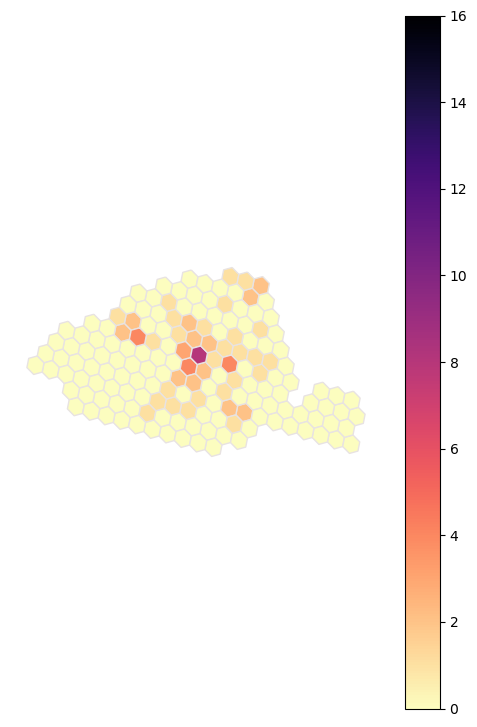

In [15]:
# Paris
query = {'amenity': 'nightclub'}
club = ox.geometries_from_place("Paris, France", tags=query)
club = club.dropna(subset=['geometry'])
gdf_nightclubs = gpd.GeoDataFrame(club, crs="EPSG:4326")

# generate hexagons
def generate_hexgrid(polygon, edge_length):
    earth_circumference = 40075.0  # Earth's circumference in kilometers
    hexagon_edge_length = edge_length  # in kilometers
    num_hexagons_around_equator = earth_circumference / hexagon_edge_length
    estimated_resolution = np.log2(num_hexagons_around_equator / 6)  # 6 hexagons per edge at equator
    resolution = int(np.round(estimated_resolution))

    hexagons = []
    for hexagon_id in h3.polyfill(polygon.__geo_interface__, resolution, geo_json_conformant=True):
        hexagons.append(Polygon(h3.h3_to_geo_boundary(hexagon_id, geo_json=True)))

    hexagon_gdf = gpd.GeoDataFrame({'geometry': hexagons}, crs="EPSG:4326")
    hexagon_gdf = hexagon_gdf.to_crs("EPSG:27561")

    return hexagon_gdf

paris_polygon = ox.geocode_to_gdf('Paris, France')['geometry'].iloc[0]
hexagons = generate_hexgrid(paris_polygon, 20)  # Edge length of 20 km

nightclubs_hex = gpd.sjoin(gdf_nightclubs.to_crs("EPSG:27561"), hexagons, how="inner", predicate='within')
nightclub_count = nightclubs_hex.groupby(nightclubs_hex.index_right).size()
hexagons['nightclub_count'] = nightclub_count.reindex(hexagons.index, fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(6,9))
hexagons.plot(column='nightclub_count', ax=ax, cmap='magma_r', edgecolor='#E8E3E2', legend=True, vmin=0, vmax=16)
plt.axis('off')
plt.savefig('paris.svg', bbox_inches='tight')
plt.show()

/var/folders/rp/0t393qy94k3_n1h8yry822hr0000gn/T/ipykernel_17537/1463547504.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  club = ox.geometries_from_place("New York City, USA", tags=query)
/Users/cyberhbliu/anaconda3/envs/musa/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/cyberhbliu/anaconda3/envs/musa/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


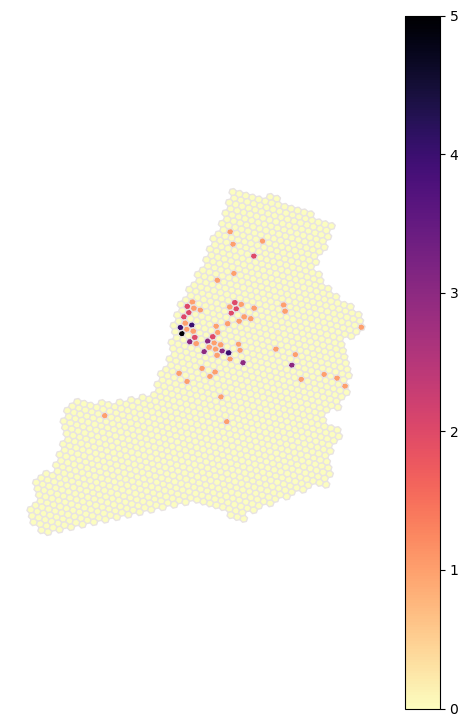

In [3]:
# NYC

query = {'amenity': 'nightclub'}
club = ox.geometries_from_place("New York City, USA", tags=query)
club = club.dropna(subset=['geometry'])
gdf_nightclubs = gpd.GeoDataFrame(club, crs="EPSG:4326")

def generate_hexgrid(polygon, edge_length):
    if isinstance(polygon, MultiPolygon):
        polygon = max(polygon.geoms, key=lambda a: a.area)
        
    earth_circumference = 40075.0  # Earth's circumference in kilometers
    hexagon_edge_length = edge_length  # in kilometers
    num_hexagons_around_equator = earth_circumference / hexagon_edge_length
    estimated_resolution = np.log2(num_hexagons_around_equator / 6)  # 6 hexagons per edge at equator
    resolution = int(np.round(estimated_resolution))

    hexagons = []
    for hexagon_id in h3.polyfill(polygon.__geo_interface__, resolution, geo_json_conformant=True):
        hexagons.append(Polygon(h3.h3_to_geo_boundary(hexagon_id, geo_json=True)))
        
    # Convert the hexagons to a GeoSeries
    hexagon_gdf = gpd.GeoDataFrame({'geometry': hexagons}, crs="EPSG:4326")
    hexagon_gdf = hexagon_gdf.to_crs("EPSG:6538")

    return hexagon_gdf

cq_polygon = ox.geocode_to_gdf("New York City, USA")['geometry'].iloc[0]
hexagons = generate_hexgrid(cq_polygon, 20)  # Edge length of 20 km
cq_polygon = gpd.GeoSeries([cq_polygon], crs="EPSG:4326").to_crs("EPSG:6538")

nightclubs_hex = gpd.sjoin(gdf_nightclubs.to_crs("EPSG:6538"), hexagons, how="inner", predicate='within')
nightclub_count = nightclubs_hex.groupby(nightclubs_hex.index_right).size()
hexagons['nightclub_count'] = nightclub_count.reindex(hexagons.index, fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(6,9))
hexagons.plot(column='nightclub_count', ax=ax, cmap='magma_r', edgecolor='#E8E3E2', legend=True)
plt.axis('off')
plt.savefig('nyc.svg', bbox_inches='tight')
plt.show()

/var/folders/rp/0t393qy94k3_n1h8yry822hr0000gn/T/ipykernel_17537/2853889414.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  club = ox.geometries_from_place("Amsterdam, Netherlands", tags=query)
/Users/cyberhbliu/anaconda3/envs/musa/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/cyberhbliu/anaconda3/envs/musa/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


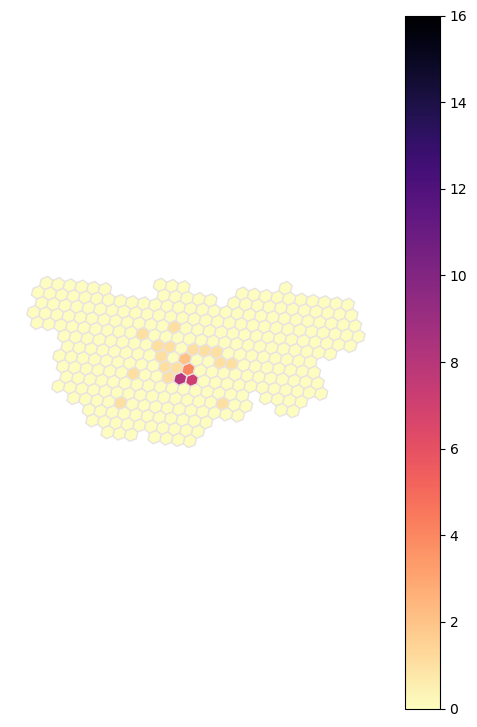

In [14]:
# Amsterdam

query = {'amenity': 'nightclub'}
club = ox.geometries_from_place("Amsterdam, Netherlands", tags=query)
club = club.dropna(subset=['geometry'])
gdf_nightclubs = gpd.GeoDataFrame(club, crs="EPSG:4326")


def generate_hexgrid(polygon, edge_length, epsg_code):
    if isinstance(polygon, MultiPolygon):
        polygon = max(polygon.geoms, key=lambda a: a.area)
    
    earth_circumference = 40075.0  # Earth's circumference in kilometers
    hexagon_edge_length = edge_length  # in kilometers
    num_hexagons_around_equator = earth_circumference / hexagon_edge_length
    estimated_resolution = np.log2(num_hexagons_around_equator / 6)  # 6 hexagons per edge at equator
    resolution = int(np.round(estimated_resolution))

    hexagons = []
    for hexagon_id in h3.polyfill(polygon.__geo_interface__, resolution, geo_json_conformant=True):
        hexagons.append(Polygon(h3.h3_to_geo_boundary(hexagon_id, geo_json=True)))
        
    # Convert the hexagons to a GeoSeries
    hexagon_gdf = gpd.GeoDataFrame({'geometry': hexagons}, crs="EPSG:4326")
    hexagon_gdf = hexagon_gdf.to_crs("EPSG:28992")

    return hexagon_gdf

am_polygon = ox.geocode_to_gdf('Amsterdam, Netherlands')['geometry'].iloc[0]
hexagons = generate_hexgrid(am_polygon, 20, "EPSG:28992")  # Edge length of 20 km
am_polygon = gpd.GeoSeries([am_polygon], crs="EPSG:4326").to_crs("EPSG:28992")

nightclubs_hex = gpd.sjoin(gdf_nightclubs.to_crs("EPSG:28992"), hexagons, how="inner", predicate='within')
nightclub_count = nightclubs_hex.groupby(nightclubs_hex.index_right).size()
hexagons['nightclub_count'] = nightclub_count.reindex(hexagons.index, fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(6,9))
hexagons.plot(column='nightclub_count', ax=ax, cmap='magma_r', edgecolor='#E8E3E2', legend=True, vmin=0, vmax=16)
plt.axis('off')
plt.savefig('amsterdam.svg', bbox_inches='tight')
plt.show()

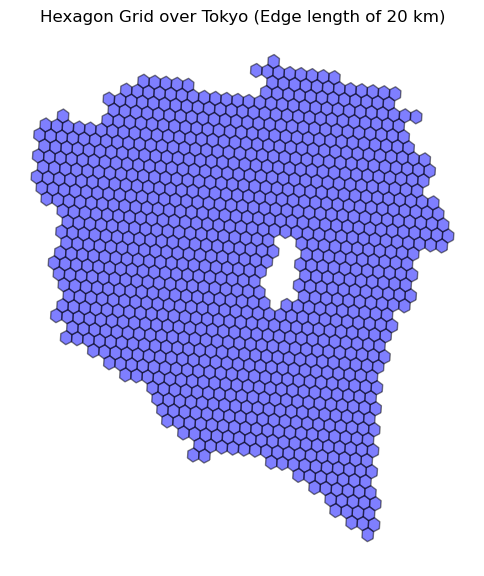

In [7]:
# Tokyo
def generate_hexgrid(polygon, edge_length, epsg_code):
    if isinstance(polygon, MultiPolygon):
        polygon = max(polygon.geoms, key=lambda a: a.area)
    
    # h3 resolution for the given edge length in km
    earth_circumference = 40075.0  # Earth's circumference in kilometers
    hexagon_edge_length = edge_length  # in kilometers
    num_hexagons_around_equator = earth_circumference / hexagon_edge_length
    estimated_resolution = np.log2(num_hexagons_around_equator / 6)  # 6 hexagons per edge at equator
    resolution = int(np.round(estimated_resolution))

    # Generate hexagons using the h3 library
    hexagons = []
    for hexagon_id in h3.polyfill(mapping(polygon), resolution, geo_json_conformant=True):
        hexagons.append(Polygon(h3.h3_to_geo_boundary(hexagon_id, geo_json=True)))

    # Convert the hexagons to a GeoSeries
    hexagon_gdf = gpd.GeoSeries(hexagons, crs="EPSG:4326")
    hexagon_gdf = hexagon_gdf.to_crs("EPSG:3095")

    return hexagon_gdf

central_wards = ['Chiyoda, Tokyo, Japan', 'Minato, Tokyo, Japan', 'Shinjuku, Tokyo, Japan', 
                 'Bunkyo, Tokyo, Japan', 'Taito, Tokyo, Japan', 'Sumida, Tokyo, Japan',
                 'Koto, Tokyo, Japan', 'Shinagawa, Tokyo, Japan', 'Meguro, Tokyo, Japan',
                 'Ota, Tokyo, Japan', 'Setagaya, Tokyo, Japan', 'Shibuya, Tokyo, Japan',
                 'Nakano, Tokyo, Japan', 'Suginami, Tokyo, Japan', 'Toshima, Tokyo, Japan',
                 'Kita, Tokyo, Japan', 'Arakawa, Tokyo, Japan', 'Itabashi, Tokyo, Japan',
                 'Nerima, Tokyo, Japan', 'Adachi, Tokyo, Japan', 'Katsushika, Tokyo, Japan',
                 'Edogawa, Tokyo, Japan']

ward_polygons = []

for ward_name in central_wards:
    ward_polygon = ox.geocode_to_gdf(ward_name)['geometry'].iloc[0]
    ward_polygons.append(ward_polygon)

tokyo_wards_geo_series = gpd.GeoSeries(ward_polygons)
ty_polygon = tokyo_wards_geo_series.unary_union


hexagons = generate_hexgrid(ty_polygon, 20, "EPSG:3095")  # Edge length of 20 km
ty_polygon = gpd.GeoSeries([ty_polygon], crs="EPSG:4326").to_crs("EPSG:3095")

# Plotting with the proper projection in meter
fig, ax = plt.subplots(figsize=(6,9))
hexagons.plot(ax=ax, color='blue', alpha=0.5, edgecolor='black')
plt.title('Hexagon Grid over Tokyo (Edge length of 20 km)')
plt.axis('off')
plt.show()

/var/folders/rp/0t393qy94k3_n1h8yry822hr0000gn/T/ipykernel_17537/3716839264.py:3: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  club = ox.geometries_from_place("Berlin, German", tags=query)
/Users/cyberhbliu/anaconda3/envs/musa/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/cyberhbliu/anaconda3/envs/musa/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


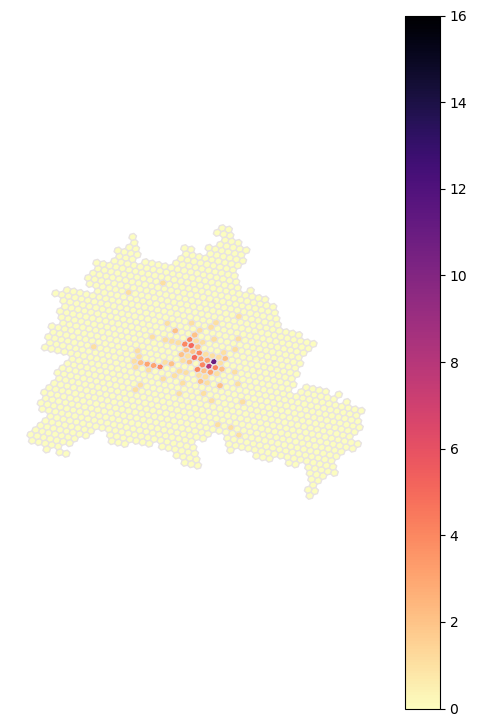

In [11]:
# Berlin
query = {'amenity': 'nightclub'}
club = ox.geometries_from_place("Berlin, German", tags=query)
club = club.dropna(subset=['geometry'])
gdf_nightclubs = gpd.GeoDataFrame(club, crs="EPSG:4326")

def generate_hexgrid(polygon, edge_length, epsg_code):
    if isinstance(polygon, MultiPolygon):
        polygon = max(polygon.geoms, key=lambda a: a.area)
    
    earth_circumference = 40075.0  # Earth's circumference in kilometers
    hexagon_edge_length = edge_length  # in kilometers
    num_hexagons_around_equator = earth_circumference / hexagon_edge_length
    estimated_resolution = np.log2(num_hexagons_around_equator / 6)  # 6 hexagons per edge at equator
    resolution = int(np.round(estimated_resolution))

    hexagons = []
    for hexagon_id in h3.polyfill(polygon.__geo_interface__, resolution, geo_json_conformant=True):
        hexagons.append(Polygon(h3.h3_to_geo_boundary(hexagon_id, geo_json=True)))
        
    # Convert the hexagons to a GeoSeries
    hexagon_gdf = gpd.GeoDataFrame({'geometry': hexagons}, crs="EPSG:4326")
    hexagon_gdf = hexagon_gdf.to_crs("EPSG:3068")

    return hexagon_gdf


#boroughs = ['Mitte, Berlin, Germany', 'Friedrichshain, Berlin, Germany', 
#            'Kreuzberg, Berlin, Germany', 'Prenzlauer Berg, Berlin, Germany', 
#            'Charlottenburg, Berlin, Germany', 'Wilmersdorf, Berlin, Germany']

#mit_polygon = ox.geocode_to_gdf('Mitte, Berlin, German')['geometry'].iloc[0]
#kze_polygon = ox.geocode_to_gdf('Mitte, Berlin, German')['geometry'].iloc[0]
#chs_polygon = ox.geocode_to_gdf('Charlottenburg-Wilmersdorf, Berlin, Germany')['geometry'].iloc[0]
#central_berlin_polygons = gpd.GeoSeries([mit_polygon, chs_polygon])

berlin_polygon = ox.geocode_to_gdf('Berlin, German')['geometry'].iloc[0]
hexagons = generate_hexgrid(berlin_polygon, 20, "EPSG:3068")  # Edge length of 20 km
berlin_polygon = gpd.GeoSeries([berlin_polygon], crs="EPSG:4326").to_crs("EPSG:3068")

nightclubs_hex = gpd.sjoin(gdf_nightclubs.to_crs("EPSG:3068"), hexagons, how="inner", predicate='within')
nightclub_count = nightclubs_hex.groupby(nightclubs_hex.index_right).size()
hexagons['nightclub_count'] = nightclub_count.reindex(hexagons.index, fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(6,9))
hexagons.plot(column='nightclub_count', ax=ax, cmap='magma_r', edgecolor='#E8E3E2', legend=True, vmin=0, vmax=16)
plt.axis('off')
plt.savefig('berlin.svg', bbox_inches='tight')
plt.show()

/var/folders/rp/0t393qy94k3_n1h8yry822hr0000gn/T/ipykernel_17537/1878811998.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  club = ox.geometries_from_place("Madrid, Spain", tags=query)
/Users/cyberhbliu/anaconda3/envs/musa/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/cyberhbliu/anaconda3/envs/musa/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


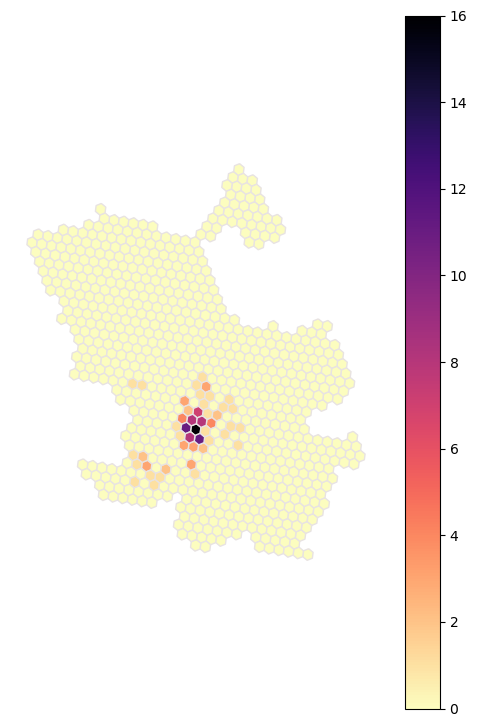

In [10]:
# Madrid

query = {'amenity': 'nightclub'}
club = ox.geometries_from_place("Madrid, Spain", tags=query)
club = club.dropna(subset=['geometry'])
gdf_nightclubs = gpd.GeoDataFrame(club, crs="EPSG:4326")

def generate_hexgrid(polygon, edge_length, epsg_code):
    if isinstance(polygon, MultiPolygon):
        polygon = max(polygon.geoms, key=lambda a: a.area)
    
    earth_circumference = 40075.0  # Earth's circumference in kilometers
    hexagon_edge_length = edge_length  # in kilometers
    num_hexagons_around_equator = earth_circumference / hexagon_edge_length
    estimated_resolution = np.log2(num_hexagons_around_equator / 6)  # 6 hexagons per edge at equator
    resolution = int(np.round(estimated_resolution))

    hexagons = []
    for hexagon_id in h3.polyfill(polygon.__geo_interface__, resolution, geo_json_conformant=True):
        hexagons.append(Polygon(h3.h3_to_geo_boundary(hexagon_id, geo_json=True)))
        
    # Convert the hexagons to a GeoSeries
    hexagon_gdf = gpd.GeoDataFrame({'geometry': hexagons}, crs="EPSG:4326")
    hexagon_gdf = hexagon_gdf.to_crs("EPSG:2062")

    return hexagon_gdf

madrid_polygon = ox.geocode_to_gdf("Madrid, Spain")['geometry'].iloc[0]
hexagons = generate_hexgrid(madrid_polygon, 20, "EPSG:2062")  # Edge length of 20 km
madrid_polygon = gpd.GeoSeries([madrid_polygon], crs="EPSG:4326").to_crs("EPSG:2062")

nightclubs_hex = gpd.sjoin(gdf_nightclubs.to_crs("EPSG:2062"), hexagons, how="inner", predicate='within')
nightclub_count = nightclubs_hex.groupby(nightclubs_hex.index_right).size()
hexagons['nightclub_count'] = nightclub_count.reindex(hexagons.index, fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(6,9))
hexagons.plot(column='nightclub_count', ax=ax, cmap='magma_r', edgecolor='#E8E3E2', legend=True, vmin=0, vmax=16)
plt.axis('off')
plt.savefig('madrid.svg', bbox_inches='tight')
plt.show()